# **Rag From Scratch: Indexing**

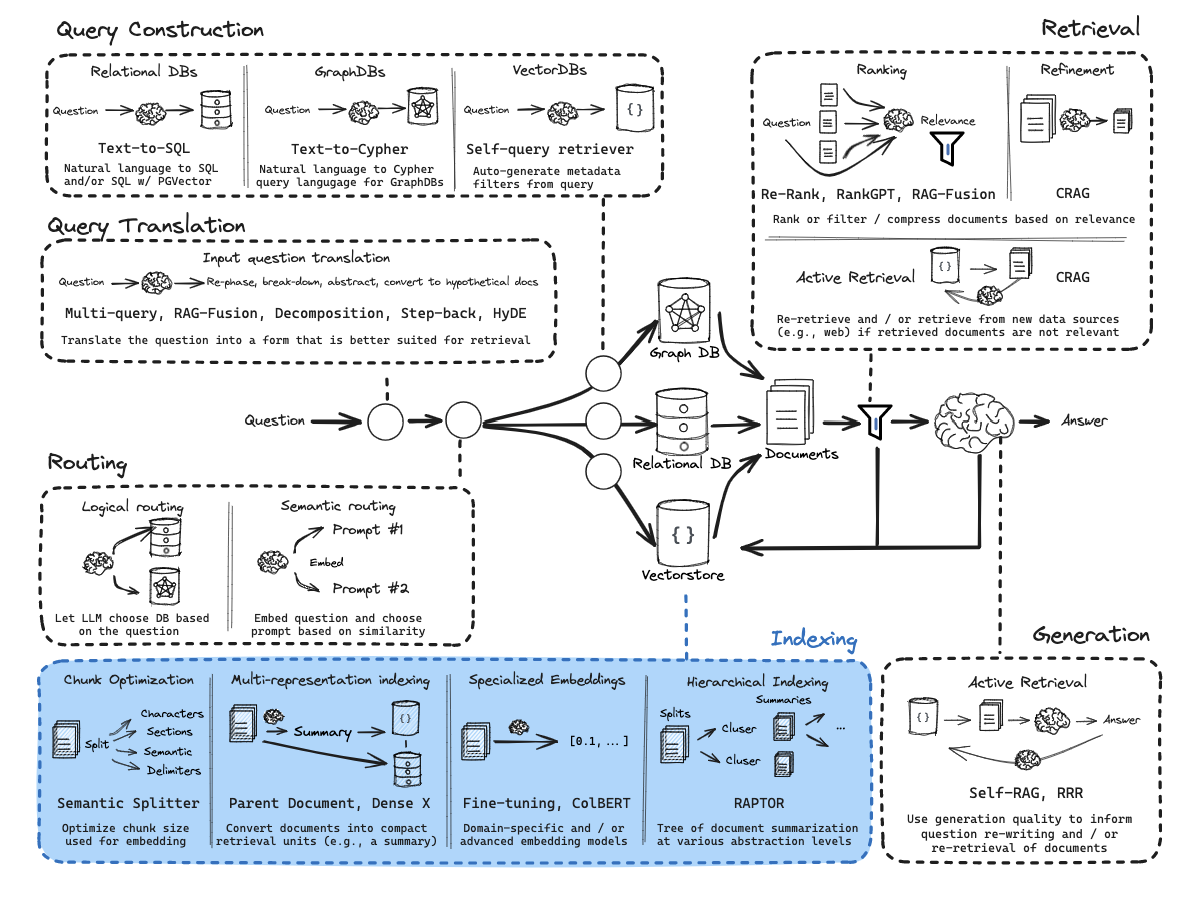

## Preface: Chunking

We don't explicity cover document chunking / splitting.

For an excellent review of document chunking, see this video from Greg Kamradt:

https://www.youtube.com/watch?v=8OJC21T2SL4

In [1]:
! pip install --upgrade --quiet langchain_community tiktoken langchain-groq langchain-huggingface langchainhub chromadb langchain youtube-transcript-api pytube

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.3/584.3 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.8/273.8 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 6.3 MB/s eta 0:00:00

In [2]:
import os
from google.colab import userdata
from uuid import uuid4

unique_id = uuid4()
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"Tracing Walkthrough - {unique_id}"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["GROQ_API_KEY"] = userdata.get('GROQ_API_KEY')
os.environ["USER_AGENT"] = "myagent"

## Part 12: Multi-representation Indexing

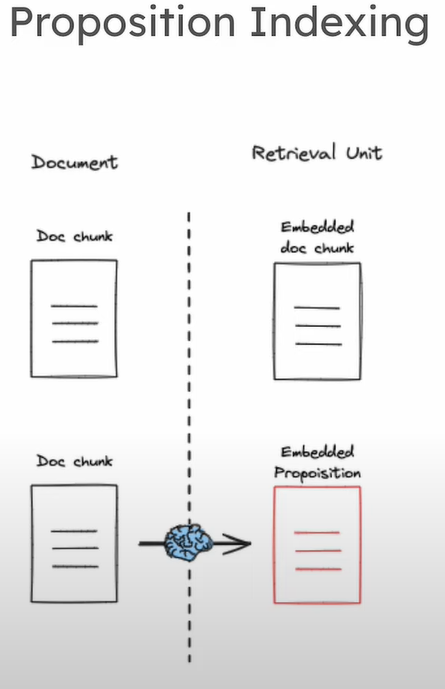

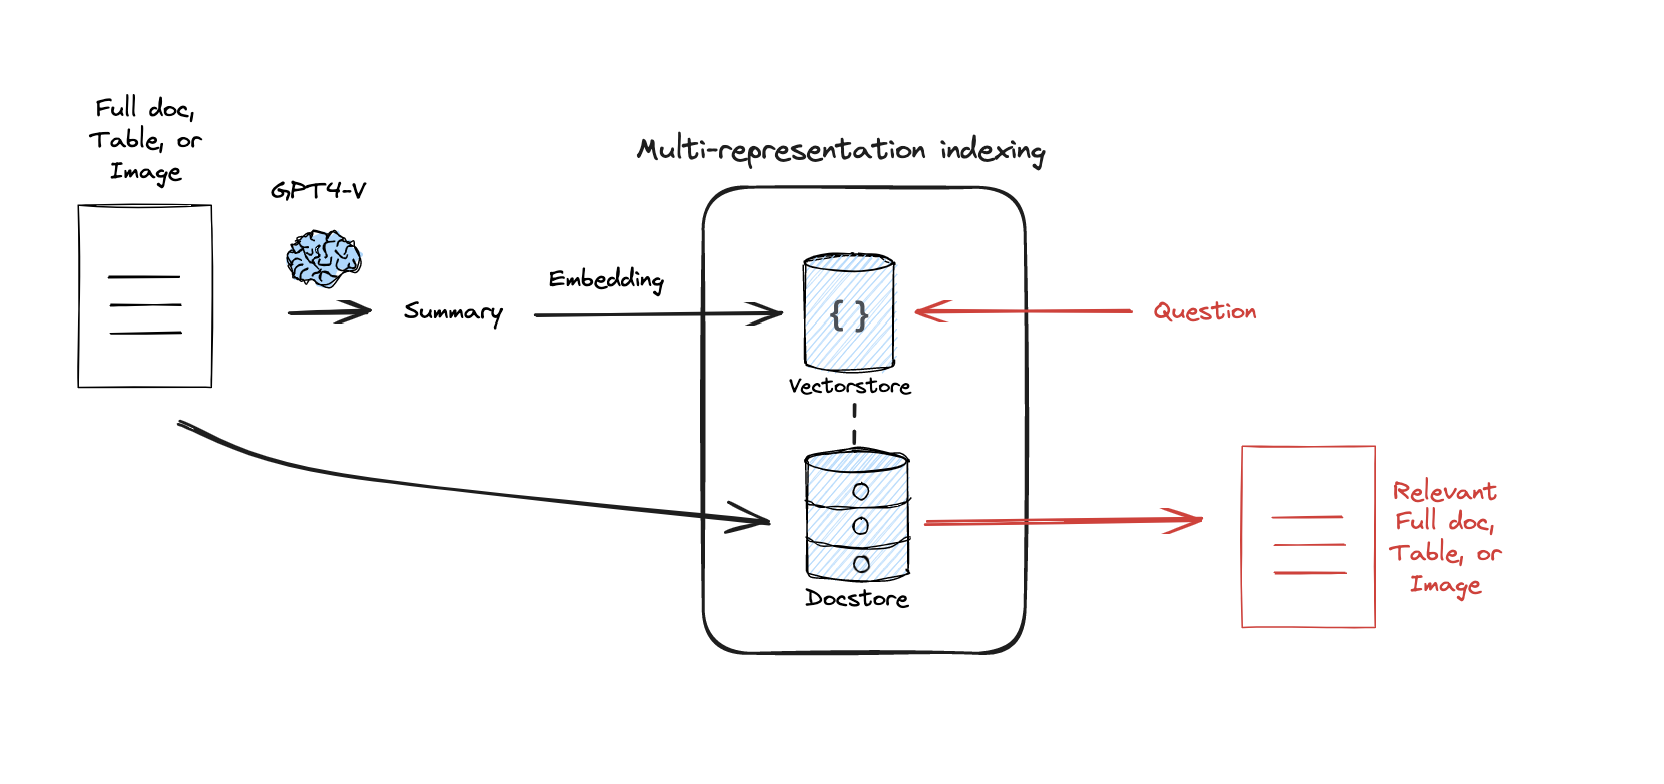

In [3]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
docs = loader.load()

loader = WebBaseLoader("https://lilianweng.github.io/posts/2024-02-05-human-data-quality/")
docs.extend(loader.load())

In [4]:
import uuid

from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq

chain = (
    {"doc": lambda x: x.page_content}
    | ChatPromptTemplate.from_template("Summarize the following document:\n\n{doc}")
    | ChatGroq(model="llama-3.1-70b-versatile", max_retries=0)
    | StrOutputParser()
)

summaries = chain.batch(docs, {"max_concurrency": 5})

In [5]:
summaries

['The document discusses the concept of LLM (Large Language Model) powered autonomous agents and their potential applications. The author, Lilian Weng, presents an overview of the key components of an LLM-powered agent system, including planning, memory, and tool use.\n\n**Planning:**\n\n* Task decomposition: breaking down complex tasks into smaller, manageable subgoals\n* Self-reflection: allowing the agent to reflect on its past actions and refine its approach\n\nThe author discusses various techniques for task decomposition, such as Chain of Thought (CoT) and Tree of Thoughts (ToT), which involve instructing the model to think step-by-step and generate multiple reasoning possibilities. Self-reflection is also discussed, with techniques such as ReAct and Reflexion, which enable the agent to reflect on its past actions and refine its approach.\n\n**Memory:**\n\n* Types of memory: sensory memory, short-term memory, and long-term memory\n* Maximum Inner Product Search (MIPS): a techniqu

In [6]:
from langchain.storage import InMemoryByteStore
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
from langchain.retrievers.multi_vector import MultiVectorRetriever

# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="summaries",
                     embedding_function=HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2"))

# The storage layer for the parent documents
store = InMemoryByteStore()
id_key = "doc_id"

# The retriever
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    byte_store=store,
    id_key=id_key,
)
doc_ids = [str(uuid.uuid4()) for _ in docs]

# Docs linked to summaries
summary_docs = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(summaries)
]

# Add
retriever.vectorstore.add_documents(summary_docs)
retriever.docstore.mset(list(zip(doc_ids, docs)))

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

<ipython-input-6-182eec396bad>:7: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the langchain-chroma package and should be used instead. To use it run `pip install -U langchain-chroma` and import as `from langchain_chroma import Chroma`.
  vectorstore = Chroma(collection_name="summaries",


In [7]:
query = "Memory in agents"
sub_docs = vectorstore.similarity_search(query,k=1)
sub_docs[0]

Document(metadata={'doc_id': '88e8111d-4a6e-4986-b27a-ed4e3b19588f'}, page_content='The document discusses the concept of LLM (Large Language Model) powered autonomous agents and their potential applications. The author, Lilian Weng, presents an overview of the key components of an LLM-powered agent system, including planning, memory, and tool use.\n\n**Planning:**\n\n* Task decomposition: breaking down complex tasks into smaller, manageable subgoals\n* Self-reflection: allowing the agent to reflect on its past actions and refine its approach\n\nThe author discusses various techniques for task decomposition, such as Chain of Thought (CoT) and Tree of Thoughts (ToT), which involve instructing the model to think step-by-step and generate multiple reasoning possibilities. Self-reflection is also discussed, with techniques such as ReAct and Reflexion, which enable the agent to reflect on its past actions and refine its approach.\n\n**Memory:**\n\n* Types of memory: sensory memory, short-te

In [8]:
retrieved_docs = retriever.get_relevant_documents(query,n_results=1)
retrieved_docs[0].page_content[0:500]

<ipython-input-8-f30970f6fe47>:1: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use invoke instead.
  retrieved_docs = retriever.get_relevant_documents(query,n_results=1)


"\n\n\n\n\n\nLLM Powered Autonomous Agents | Lil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ\n\n\n\n\nemojisearch.app\n\n\n\n\n\n\n\n\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\n \n\n\nTable of Contents\n\n\n\nAgent System Overview\n\nComponent One: Planning\n\nTask Decomposition\n\nSelf-Reflection\n\n\nComponent Two: Memory\n\nTypes of Memory\n\nMaximum Inner Product Search (MIPS)\n\n"

Related idea is the parent document retriever: https://python.langchain.com/docs/how_to/parent_document_retriever/.

## Part 13: RAPTOR

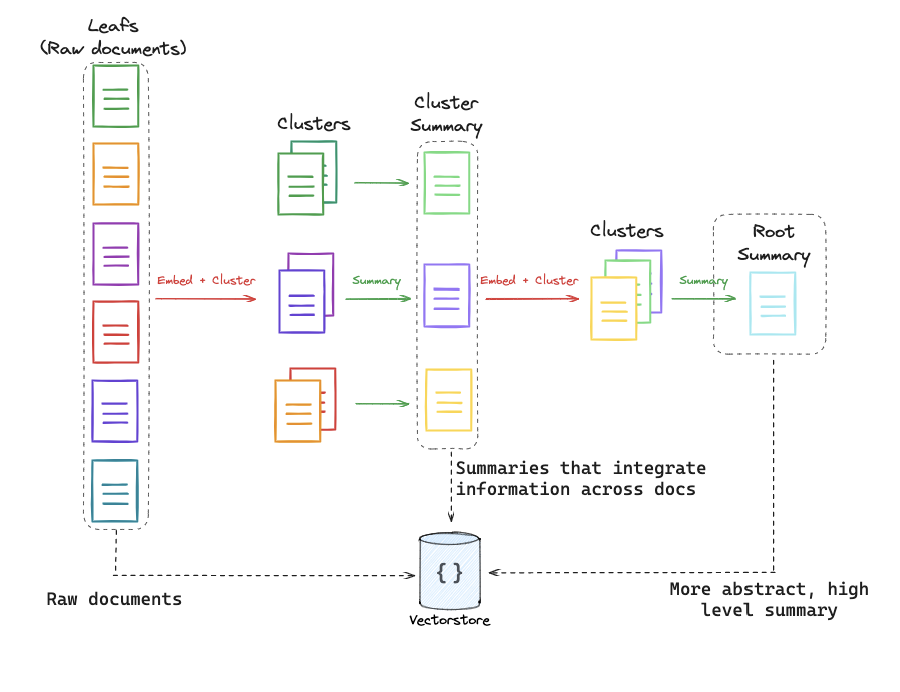

Deep dive video:

https://www.youtube.com/watch?v=jbGchdTL7d0

Paper:

https://arxiv.org/pdf/2401.18059.pdf

Full code:

https://github.com/langchain-ai/langchain/blob/master/cookbook/RAPTOR.ipynb

## Part 14: ColBERT

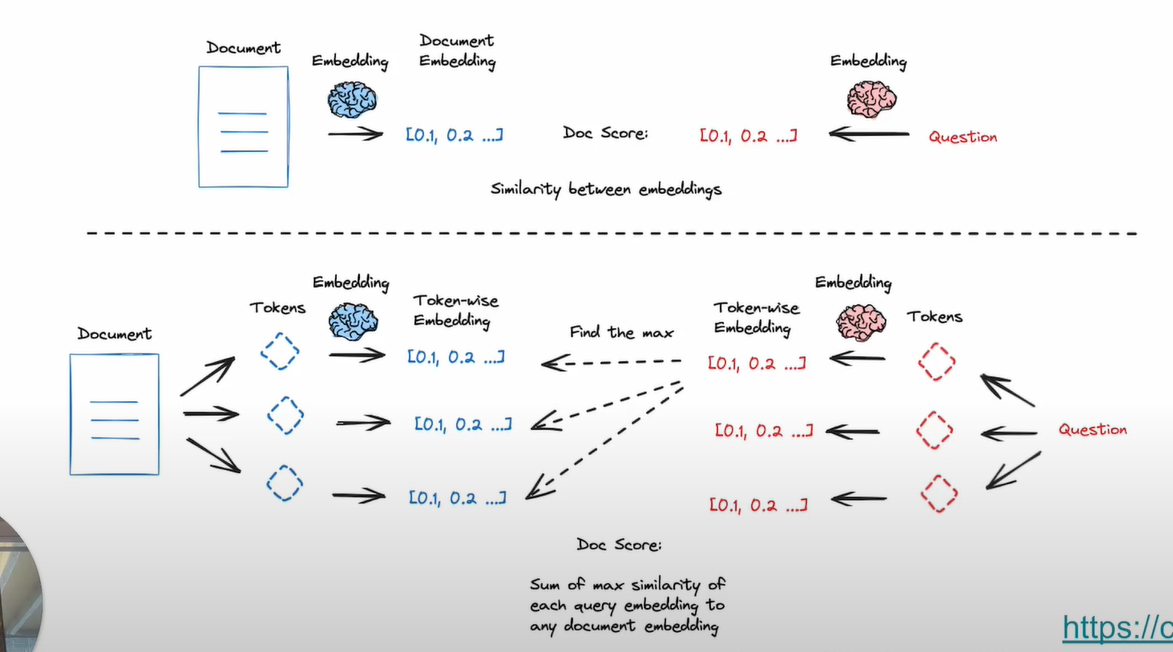

RAGatouille makes it as simple to use ColBERT.

ColBERT generates a contextually influenced vector for each token in the passages.

ColBERT similarly generates vectors for each token in the query.

Then, the score of each document is the sum of the maximum similarity of each query embedding to any of the document embeddings:

See [here](https://hackernoon.com/how-colbert-helps-developers-overcome-the-limits-of-rag) and [here](https://python.langchain.com/docs/integrations/retrievers/ragatouille) and [here](https://til.simonwillison.net/llms/colbert-ragatouille).

In [9]:
! pip install -U ragatouille

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.3/288.3 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━

In [10]:
from ragatouille import RAGPretrainedModel
RAG = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


artifact.metadata:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/405 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

[Sep 18, 16:39:59] Loading segmented_maxsim_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.a

In [11]:
import requests

def get_wikipedia_page(title: str):
    """
    Retrieve the full text content of a Wikipedia page.

    :param title: str - Title of the Wikipedia page.
    :return: str - Full text content of the page as raw string.
    """
    # Wikipedia API endpoint
    URL = "https://en.wikipedia.org/w/api.php"

    # Parameters for the API request
    params = {
        "action": "query",
        "format": "json",
        "titles": title,
        "prop": "extracts",
        "explaintext": True,
    }

    # Custom User-Agent header to comply with Wikipedia's best practices
    headers = {"User-Agent": "RAGatouille_tutorial/0.0.1 (ben@clavie.eu)"}

    response = requests.get(URL, params=params, headers=headers)
    data = response.json()

    # Extracting page content
    page = next(iter(data["query"]["pages"].values()))
    return page["extract"] if "extract" in page else None

full_document = get_wikipedia_page("Hayao_Miyazaki")

In [12]:
RAG.index(
    collection=[full_document],
    index_name="Miyazaki-123",
    max_document_length=180,
    split_documents=True,
)

---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Sep 18, 16:40:42] #> Creating directory .ragatouille/colbert/indexes/Miyazaki-123 


[Sep 18, 16:40:43] [0] 		 #> Encoding 121 passages..


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:265: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
100%|██████████| 4/4 [01:18<00:00, 19.63s/it]

[Sep 18, 16:42:02] [0] 		 avg_doclen_est = 131.35537719726562 	 len(local_sample) = 121
[Sep 18, 16:42:02] [0] 		 Creating 1,024 partitions.
[Sep 18, 16:42:02] [0] 		 *Estimated* 15,894 embeddings.
[Sep 18, 16:42:02] [0] 		 #> Saving the indexing plan to .ragatouille/colbert/indexes/Miyazaki-123/plan.json ..



/usr/local/lib/python3.10/dist-packages/colbert/indexing/collection_indexer.py:256: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sub_sample = torch.load(sub_sample_path)
/

used 17 iterations (6.5118s) to cluster 15100 items into 1024 clusters
[0.038, 0.042, 0.042, 0.038, 0.034, 0.038, 0.036, 0.039, 0.033, 0.035, 0.038, 0.038, 0.034, 0.037, 0.037, 0.042, 0.032, 0.035, 0.037, 0.041, 0.036, 0.037, 0.036, 0.04, 0.038, 0.034, 0.041, 0.036, 0.037, 0.039, 0.036, 0.038, 0.039, 0.034, 0.036, 0.034, 0.039, 0.039, 0.036, 0.043, 0.037, 0.043, 0.036, 0.035, 0.038, 0.034, 0.037, 0.038, 0.038, 0.033, 0.036, 0.037, 0.036, 0.039, 0.037, 0.036, 0.04, 0.04, 0.042, 0.034, 0.036, 0.035, 0.035, 0.037, 0.038, 0.038, 0.038, 0.037, 0.034, 0.036, 0.036, 0.035, 0.036, 0.035, 0.038, 0.035, 0.037, 0.04, 0.038, 0.034, 0.037, 0.039, 0.035, 0.041, 0.033, 0.039, 0.038, 0.037, 0.033, 0.043, 0.034, 0.038, 0.038, 0.038, 0.036, 0.037, 0.038, 0.036, 0.041, 0.036, 0.043, 0.041, 0.039, 0.037, 0.037, 0.037, 0.037, 0.035, 0.037, 0.032, 0.038, 0.039, 0.039, 0.035, 0.04, 0.039, 0.036, 0.039, 0.039, 0.043, 0.036, 0.032, 0.037, 0.038, 0.035, 0.038, 0.039, 0.039]


0it [00:00, ?it/s]

[Sep 18, 16:42:08] [0] 		 #> Encoding 121 passages..



100%|██████████| 4/4 [01:08<00:00, 17.13s/it]
1it [01:08, 68.96s/it]
  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/colbert/indexing/codecs/residual_embeddings.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an 

[Sep 18, 16:43:17] #> Optimizing IVF to store map from centroids to list of pids..
[Sep 18, 16:43:17] #> Building the emb2pid mapping..
[Sep 18, 16:43:17] len(emb2pid) = 15894



100%|██████████| 1024/1024 [00:00<00:00, 29226.41it/s]

[Sep 18, 16:43:17] #> Saved optimized IVF to .ragatouille/colbert/indexes/Miyazaki-123/ivf.pid.pt
Done indexing!


'.ragatouille/colbert/indexes/Miyazaki-123'

In [13]:
results = RAG.search(query="What animation studio did Miyazaki found?", k=3)
results

Loading searcher for index Miyazaki-123 for the first time... This may take a few seconds
[Sep 18, 16:43:18] #> Loading codec...
[Sep 18, 16:43:18] #> Loading IVF...
[Sep 18, 16:43:18] Loading segmented_lookup_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


/usr/local/lib/python3.10/dist-packages/colbert/search/index_loader.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ivf, ivf_lengths = torch.load(os.path.join(self.inde

[Sep 18, 16:43:51] #> Loading doclens...


100%|██████████| 1/1 [00:00<00:00, 557.60it/s]

[Sep 18, 16:43:51] #> Loading codes and residuals...



  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/colbert/indexing/codecs/residual_embeddings.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


[Sep 18, 16:43:51] Loading filter_pids_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


[Sep 18, 16:44:24] Loading decompress_residuals_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...
Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: . What animation studio did Miyazaki found?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  7284,  2996,  2106,  2771,  3148, 18637,  2179,
         1029,   102,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103])
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])



/usr/local/lib/python3.10/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:265: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


[{'content': '=== Studio Ghibli ===\n\n\n==== Early films (1985–1995) ====\nFollowing the success of Nausicaä of the Valley of the Wind, Miyazaki and Takahata founded the animation production company Studio Ghibli on June 15, 1985, as a subsidiary of Tokuma Shoten, with offices in Kichijōji designed by Miyazaki. Miyazaki named the studio after the Caproni Ca.309 and the Italian word meaning "a hot wind that blows in the desert"; the name had been registered a year earlier.',
  'score': 25.86235809326172,
  'rank': 1,
  'document_id': '67fa93dc-33ab-49f1-8974-ad91f246eaae',
  'passage_id': 42},
 {'content': 'Hayao Miyazaki (宮崎 駿 or 宮﨑 駿, Miyazaki Hayao, Japanese: [mijaꜜzaki hajao]; born January 5, 1941) is a Japanese animator, filmmaker, and manga artist. A founder of Studio Ghibli, he has attained international acclaim as a masterful storyteller and creator of Japanese animated feature films, and is widely regarded as one of the most accomplished filmmakers in the history of animation.

In [14]:
retriever = RAG.as_langchain_retriever(k=3)
retriever.invoke("What animation studio did Miyazaki found?")

/usr/local/lib/python3.10/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:265: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


[Document(metadata={}, page_content='=== Studio Ghibli ===\n\n\n==== Early films (1985–1995) ====\nFollowing the success of Nausicaä of the Valley of the Wind, Miyazaki and Takahata founded the animation production company Studio Ghibli on June 15, 1985, as a subsidiary of Tokuma Shoten, with offices in Kichijōji designed by Miyazaki. Miyazaki named the studio after the Caproni Ca.309 and the Italian word meaning "a hot wind that blows in the desert"; the name had been registered a year earlier.'),
 Document(metadata={}, page_content='Hayao Miyazaki (宮崎 駿 or 宮﨑 駿, Miyazaki Hayao, Japanese: [mijaꜜzaki hajao]; born January 5, 1941) is a Japanese animator, filmmaker, and manga artist. A founder of Studio Ghibli, he has attained international acclaim as a masterful storyteller and creator of Japanese animated feature films, and is widely regarded as one of the most accomplished filmmakers in the history of animation.\nBorn in Tokyo City, Miyazaki expressed interest in manga and animation f